In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import numpy as np

# Global Variables
DUMMY_USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
MAX_HOLDERS_SHOWN = 1000
MAX_HOLDERS_PER_PAGE = 50
MAX_PAGES = int(MAX_HOLDERS_SHOWN / MAX_HOLDERS_PER_PAGE)

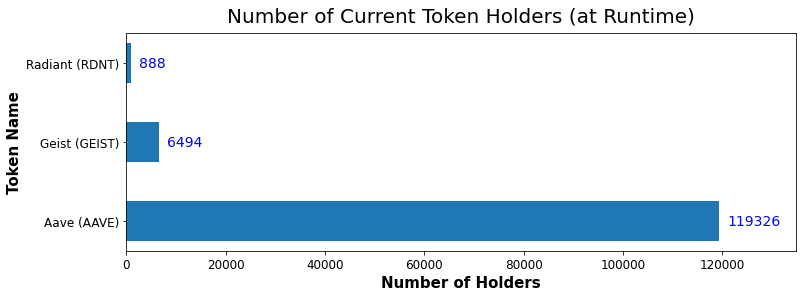

In [7]:
## Plot the number of holders for each token

# Blockchain explorer URLs
aave_token_url = 'https://etherscan.io/token/0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9#balances'
geist_token_url = 'https://ftmscan.com/token/0xd8321aa83fb0a4ecd6348d4577431310a6e0814d#balances'
radiant_token_url = 'https://arbiscan.io/token/0x0c4681e6c0235179ec3d4f4fc4df3d14fdd96017#balances'

# Get the HTML for each token
# Note: Requests to Etherscan will fail if the User-Agent header is missing
aave_token_html = BeautifulSoup(requests.get(aave_token_url, headers={'User-Agent': DUMMY_USER_AGENT}).text, 'html.parser')
geist_token_html = BeautifulSoup(requests.get(geist_token_url).text, 'html.parser')
radiant_token_html = BeautifulSoup(requests.get(radiant_token_url).text, 'html.parser')

# Scrape the number of holders from the html
aave_number_of_holders = int(aave_token_html.find(id="ContentPlaceHolder1_tr_tokenHolders").find('div', {'class': 'mr-3'}).text.split(' ')[0].split('\n')[1].replace(',',''))
geist_number_of_holders = int(geist_token_html.find(id="ContentPlaceHolder1_tr_tokenHolders").find('div', {'class': 'col-md-8'}).text.split(' ')[0].split('\n')[1].replace(',',''))
radiant_number_of_holders = int(radiant_token_html.find(id="ContentPlaceHolder1_tr_tokenHolders").find('div', {'class': 'mr-3'}).text.split(' ')[36])
    
# Create a dictionary to store the number of holders 
number_of_holders = {
    'Aave': aave_number_of_holders,
    'Geist': geist_number_of_holders,
    'Radiant': radiant_number_of_holders
}

token_names = {
    'Aave': 'Aave (AAVE)',
    'Geist': 'Geist (GEIST)',
    'Radiant': 'Radiant (RDNT)'
}

# Figure Size
fig, ax = plt.subplots(figsize =(12, 4))
 
# Horizontal Bar Plot
bar_container = ax.barh(list(token_names.values()), list(number_of_holders.values()), height=0.5)

# Add Plot Title
ax.set_title(
    'Number of Current Token Holders (at Runtime)',
    fontdict={
        'fontsize': 20
    },
    loc='center',
    pad=12
)

# Label Axes
plt.xlabel('Number of Holders', fontweight ='bold', fontsize = 15)
plt.ylabel('Token Name', fontweight ='bold', fontsize = 15)

# Set Tick Size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add Bar Labels
plt.bar_label(bar_container, padding=8, color='b', fontsize=14)

# Add Padding on X Axis to Make Room for Bar Labels 
plt.axis(xmax=max([aave_number_of_holders, geist_number_of_holders, radiant_number_of_holders])*1.13)

# Show Plot
plt.show()

In [ ]:
# Unused block (Reading from CSV File)

# aave_holders_raw = pd.read_csv('aave-token-holders.csv')
# geist_holders_raw = pd.read_csv('geist-token-holders.csv')
# radiant_holders_raw = pd.read_csv('radiant-token-holders.csv')

# Clean Data (Part I)
# Remove rows with the zero address
# aave_holders_first_clean = aave_holders_raw[aave_holders_raw['HolderAddress'] != '0x0000000000000000000000000000000000000000']
# geist_holders_first_clean = geist_holders_raw[geist_holders_raw['HolderAddress'] != '0x0000000000000000000000000000000000000000']
# radiant_holders_first_clean = radiant_holders_raw[radiant_holders_raw['HolderAddress'] != '0x0000000000000000000000000000000000000000']

# Clean Data (Part II)
# Remove rows with zero balance
# aave_holders = aave_holders_first_clean[aave_holders_first_clean['Balance'] != 0]
# geist_holders = geist_holders_first_clean[geist_holders_first_clean['Balance'] != 0]
# radiant_holders = radiant_holders_first_clean[radiant_holders_first_clean['Balance'] != 0]

In [ ]:
aave_number_of_institutional_holders = 0
aave_holders_page_number = 1
aave_number_of_wallets_checked = 0

aave_holders_base_url = 'https://etherscan.io/token/generic-tokenholders2?a=0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9&sid=&m=normal&s=16000000000000000000000000'

# Request the first page of token holders
aave_holders_request = requests.get(aave_holders_base_url + '&p=' + str(aave_holders_page_number), headers={'User-Agent': DUMMY_USER_AGENT})

# If the status code is 200
# Note that a 200 status code does not guarantee a table of token holders
if aave_holders_request.status_code == 200:
    
    # Find the element with the id 'maintable'
    main_table = BeautifulSoup(aave_holders_request.text, 'html.parser').find(id='maintable')
    
    # The the table column which stores the wallet address 
    ETHEREUM_ADDRESS_COULMN = 1
    
    while main_table is not None:
        # Parse table
        print('Parsing Aave html table on webpage ' + str(aave_holders_page_number))
        
        # HTML table rows
        rows = main_table.find_all('tr')
        
        # For each row
        for row in range(1,len(rows)):
            # Increment the number of wallets checked
            aave_number_of_wallets_checked += 1
            
            # Grab the html element that contains the wallet data
            wallet_address_element = rows[row].find_all('td')[ETHEREUM_ADDRESS_COULMN]
            
            # Extract the wallet address
            wallet_address = wallet_address_element.find('a').string
            
            # If a hex string is not provided
            if not wallet_address.startswith('0x'):
                # Increment the number of institutional holders
                aave_number_of_institutional_holders += 1
          
        # Log the total number of institutional holders so far
        # print(str(aave_number_of_institutional_holders) + ' total institutional wallet addresses up to page ' + str(aave_holders_page_number))

        # Increment the page number
        aave_holders_page_number += 1

        # Make the http request
        aave_holders_request = requests.get(aave_holders_base_url + '&p=' + str(aave_holders_page_number), headers={'User-Agent': DUMMY_USER_AGENT})

        # If the status code is 200
        if aave_holders_request.status_code == 200:
            # Find the element with the id 'maintable'
            main_table = BeautifulSoup(aave_holders_request.text, 'html.parser').find(id='maintable')
        else:
            print('Received bad status code for AAVE holders page ' + str(aave_holders_page_number))
            
            # Set the main table to None
            main_table = None
            
            # Break the while loop
            break
    
    print('Completed parsing all Aave data tables. Checked ' + str(aave_number_of_wallets_checked) + ' wallet addresses')
    
    # Creating dataset
    categories = ['Retail', 'Institutional']
    data = [aave_number_of_wallets_checked - aave_number_of_institutional_holders, aave_number_of_institutional_holders]

    # Creating explode data
    explode = (0.0, 0.2)

    # Creating color parameters
    colors = ( "beige", "cyan")

    # Wedge properties
    wp = { 'linewidth' : 1, 'edgecolor' : "orange" }

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n".format(pct, absolute)

    # Creating plot
    fig, ax = plt.subplots(figsize =(10, 7))
    wedges, texts, autotexts = ax.pie(data,
                                      autopct = lambda pct: func(pct, data),
                                      explode = explode,
                                      labels = categories,
                                      shadow = False,
                                      colors = colors,
                                      startangle = 45,
                                      wedgeprops = wp,
                                      textprops = dict(color ="green", fontsize=15))

    plt.setp(autotexts, size = 15, weight ="bold")
    ax.set_title(
        "Aave Institutional vs Retail Investors",
        fontdict={
            'fontsize': 20
        },
        loc='center',
        pad=12
    )

    # show plot
    plt.show()
        
else:
    print('Received bad status code for AAVE holders page ' + str(aave_holders_page_number))



In [ ]:
geist_number_of_institutional_holders = 0
geist_holders_page_number = 1
geist_number_of_wallets_checked = 0

geist_holders_base_url = 'https://ftmscan.com/token/generic-tokenholders2?a=0xd8321aa83fb0a4ecd6348d4577431310a6e0814d&sid=&m=normal&s=16000000000000000000000000'

# Request the first page of token holders
geist_holders_request = requests.get(geist_holders_base_url + '&p=' + str(geist_holders_page_number), headers={'User-Agent': DUMMY_USER_AGENT})

# If the status code is 200
# Note that a 200 status code does not guarantee a table of token holders
if geist_holders_request.status_code == 200:
    
    # Find the element with the id 'maintable'
    main_table = BeautifulSoup(geist_holders_request.text, 'html.parser').find(id='maintable')
    
    # The the table column which stores the wallet address 
    FANTOM_ADDRESS_COULMN = 1
    
    while main_table is not None:
        # Parse table
        print('Parsing Geist html table on webpage ' + str(geist_holders_page_number))
        
        # HTML table rows
        rows = main_table.find_all('tr')
        
        # For each row
        for row in range(1,len(rows)):
            # Increment the number of wallets checked
            geist_number_of_wallets_checked += 1
            
            # Grab the html element that contains the wallet data
            wallet_address_element = rows[row].find_all('td')[FANTOM_ADDRESS_COULMN]
            
            # Extract the wallet address
            wallet_address = wallet_address_element.find('a').string
            
            # If a hex string is not provided
            if not wallet_address.startswith('0x'):
                # Increment the number of institutional holders
                geist_number_of_institutional_holders += 1
          
        # Log the total number of institutional holders so far
        # print(str(geist_number_of_institutional_holders) + ' total institutional wallet addresses up to page ' + str(geist_holders_page_number))

        # Increment the page number
        geist_holders_page_number += 1

        # Make the http request
        geist_holders_request = requests.get(geist_holders_base_url + '&p=' + str(geist_holders_page_number), headers={'User-Agent': DUMMY_USER_AGENT})

        # If the status code is 200
        if geist_holders_request.status_code == 200:
            # Find the element with the id 'maintable'
            main_table = BeautifulSoup(geist_holders_request.text, 'html.parser').find(id='maintable')
        else:
            print('Received bad status code for GEIST holders page ' + str(geist_holders_page_number))
            
            # Set the main table to None
            main_table = None
            
            # Break the while loop
            break
    
    print('Completed parsing all Geist data tables. Checked ' + str(geist_number_of_wallets_checked) + ' wallet addresses')
    
    # Creating dataset
    categories = ['Retail', 'Institutional']
    data = [geist_number_of_wallets_checked - geist_number_of_institutional_holders, geist_number_of_institutional_holders]

    # Creating explode data
    explode = (0.0, 0.2)

    # Creating color parameters
    colors = ( "beige", "cyan")

    # Wedge properties
    wp = { 'linewidth' : 1, 'edgecolor' : "orange" }

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n".format(pct, absolute)

    # Creating plot
    fig, ax = plt.subplots(figsize =(10, 7))
    wedges, texts, autotexts = ax.pie(data,
                                      autopct = lambda pct: func(pct, data),
                                      explode = explode,
                                      labels = categories,
                                      shadow = False,
                                      colors = colors,
                                      startangle = 45,
                                      wedgeprops = wp,
                                      textprops = dict(color ="green", fontsize=15))

    plt.setp(autotexts, size = 15, weight ="bold")
    ax.set_title(
        "Geist Institutional vs Retail Investors",
        fontdict={
            'fontsize': 20
        },
        loc='center',
        pad=12
    )

    # show plot
    plt.show()
        
else:
    print('Received bad status code for GEIST holders page ' + str(geist_holders_page_number))



In [ ]:
radiant_number_of_institutional_holders = 0
radiant_holders_page_number = 1
radiant_number_of_wallets_checked = 0

radiant_holders_base_url = 'https://arbiscan.io/token/generic-tokenholders2?a=0x0c4681e6c0235179ec3d4f4fc4df3d14fdd96017&sid=&m=normal&s=16000000000000000000000000'

# Request the first page of token holders
radiant_holders_request = requests.get(radiant_holders_base_url + '&p=' + str(radiant_holders_page_number), headers={'User-Agent': DUMMY_USER_AGENT})

# If the status code is 200
# Note that a 200 status code does not guarantee a table of token holders
if radiant_holders_request.status_code == 200:
    
    # Find the element with the id 'maintable'
    main_table = BeautifulSoup(radiant_holders_request.text, 'html.parser').find(id='maintable')
    
    # The the table column which stores the wallet address 
    ARBITRUM_ADDRESS_COULMN = 1
    
    # While the first row is not an alert message
    while main_table.find_all('tr')[1].find('div', {'class': 'alert'}) is None:
        # Parse table
        print('Parsing Radiant html table on webpage ' + str(radiant_holders_page_number))
        
        # HTML table rows
        rows = main_table.find_all('tr')
        
        # For each row
        for row in range(1,len(rows)):
            # Increment the number of wallets checked
            radiant_number_of_wallets_checked += 1
            
            # Grab the html element that contains the wallet data
            wallet_address_element = rows[row].find_all('td')[ARBITRUM_ADDRESS_COULMN]
            
            # Extract the wallet address
            wallet_address = wallet_address_element.find('a').string
            
            # If a hex string is not provided
            if not wallet_address.startswith('0x'):
                # Increment the number of institutional holders
                radiant_number_of_institutional_holders += 1
          
        # Log the total number of institutional holders so far
        # print(str(radiant_number_of_institutional_holders) + ' total institutional wallet addresses up to page ' + str(radiant_holders_page_number))

        # Increment the page number
        radiant_holders_page_number += 1

        # Make the http request
        radiant_holders_request = requests.get(radiant_holders_base_url + '&p=' + str(radiant_holders_page_number), headers={'User-Agent': DUMMY_USER_AGENT})

        # If the status code is 200
        if radiant_holders_request.status_code == 200:
            # Find the element with the id 'maintable'
            main_table = BeautifulSoup(radiant_holders_request.text, 'html.parser').find(id='maintable')
        else:
            print('Received bad status code for Radiant holders page ' + str(radiant_holders_page_number))
            
            # Set the main table to None
            main_table = None
            
            # Break the while loop
            break
    
    print('Completed parsing all Radiant data tables. Checked ' + str(radiant_number_of_wallets_checked) + ' wallet addresses')
    
    # Creating dataset
    categories = ['Retail', 'Institutional']
    data = [radiant_number_of_wallets_checked - radiant_number_of_institutional_holders, radiant_number_of_institutional_holders]

    # Creating explode data
    explode = (0.0, 0.2)

    # Creating color parameters
    colors = ( "beige", "cyan")

    # Wedge properties
    wp = { 'linewidth' : 1, 'edgecolor' : "orange" }

    # Creating autocpt arguments
    def func(pct, allvalues):
        absolute = int(pct / 100.*np.sum(allvalues))
        return "{:.1f}%\n".format(pct, absolute)

    # Creating plot
    fig, ax = plt.subplots(figsize =(10, 7))
    wedges, texts, autotexts = ax.pie(data,
                                      autopct = lambda pct: func(pct, data),
                                      explode = explode,
                                      labels = categories,
                                      shadow = False,
                                      colors = colors,
                                      startangle = 45,
                                      wedgeprops = wp,
                                      textprops = dict(color ="green", fontsize=15))

    plt.setp(autotexts, size = 15, weight ="bold")
    ax.set_title(
        "Radiant Institutional vs Retail Investors",
        fontdict={
            'fontsize': 20
        },
        loc='center',
        pad=12
    )

    # show plot
    plt.show()
        
else:
    print('Received bad status code for RDNT holders page ' + str(radiant_holders_page_number))



In [ ]:
assets_to_borrow = ['DAI', 'USDC', 'USDT', 'ETH', 'WBTC']
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Borrow APY Rates (%, Variable) 
# DAI, USDC, USDT, ETH, WBTC
aave_borrow_rates = [1.58, 1.77, 2.35, 1.89, 0.53]
geist_borrow_rates = [2.25, 2.6, 3.89, 0.83, 0.71]
radiant_borrow_rates = [7.98, 6.58, 7.17, 12.86, 14.89]
 
# Set position of bar on X axis
br1 = np.arange(len(assets_to_borrow))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, aave_borrow_rates, color ='r', width = barWidth, edgecolor ='grey', label ='Aave')
plt.bar(br2, geist_borrow_rates, color ='g', width = barWidth, edgecolor ='grey', label ='Geist')
plt.bar(br3, radiant_borrow_rates, color ='b', width = barWidth, edgecolor ='grey', label ='Radiant')
 
# X Ticks
plt.xlabel('Token', fontweight ='bold', fontsize = 15)
plt.ylabel('Variable APY (%)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(assets_to_borrow))], assets_to_borrow, fontsize=12)

# Y Ticks
plt.yticks(fontsize=12)

# Add Title
plt.title(
    'Interest Rates for Borrowing (as of August 7, 2022)',
    fontdict={
        'fontsize': 20
    },
    loc='center',
    pad=12
)
 
plt.legend()
plt.show()

In [ ]:
assets_to_borrow = ['DAI', 'USDC', 'USDT', 'ETH', 'WBTC']
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Borrow APY Rates (%, Variable) 
# DAI, USDC, USDT, ETH, WBTC
aave_borrow_rates = [0, 0, 0, 0, 0]
geist_borrow_rates = [3.64, 1.4, 2.73, 4.03, 3.97]
radiant_borrow_rates = [16.38, 13.09, 13.49, 22.16, 27.12]
 
# Set position of bar on X axis
br1 = np.arange(len(assets_to_borrow))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, aave_borrow_rates, color ='r', width = barWidth, edgecolor ='grey', label ='Aave')
plt.bar(br2, geist_borrow_rates, color ='g', width = barWidth, edgecolor ='grey', label ='Geist')
plt.bar(br3, radiant_borrow_rates, color ='b', width = barWidth, edgecolor ='grey', label ='Radiant')
 
# X Ticks
plt.xlabel('Token', fontweight ='bold', fontsize = 15)
plt.ylabel('Variable APY (%)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(assets_to_borrow))], assets_to_borrow, fontsize=12)

# Y Ticks
plt.yticks(fontsize=12)

# Add Title
plt.title(
    'Reward Rates for Borrowing (as of August 7, 2022)',
    fontdict={
        'fontsize': 20
    },
    loc='center',
    pad=12
)
 
plt.legend()
plt.show()

In [ ]:
assets_to_lend = ['DAI', 'USDC', 'USDT', 'ETH', 'WBTC']
 
# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# Lend APY Rates (%, Variable) 
# DAI, USDC, USDT, ETH, WBTC
# TODO: Make this a stacked bar chart
aave_lend_rates = [0, 0, 0, 0.75, 0]
geist_lend_rates = [
    0.51 + 0.54,
    0.76 + 0.27,
    1.7 + 0.78,
    0.03 + 0.09,
    0.02 + 0.08
]
radiant_lend_rates = [
    3.11 + 13.14,
    2.34 + 9.53,
    2.78 + 10.68,
    3.88 + 13.94,
    4.63 + 17.67
]
 
# Set position of bar on X axis
br1 = np.arange(len(assets_to_lend))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, aave_lend_rates, color ='r', width = barWidth, edgecolor ='grey', label ='Aave')
plt.bar(br2, geist_lend_rates, color ='g', width = barWidth, edgecolor ='grey', label ='Geist')
plt.bar(br3, radiant_lend_rates, color ='b', width = barWidth, edgecolor ='grey', label ='Radiant')
 
# X Ticks
plt.xlabel('Token', fontweight ='bold', fontsize = 15)
plt.ylabel('Variable APY (%)', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(assets_to_lend))], assets_to_lend, fontsize=12)

# Y Ticks
plt.yticks(fontsize=12)

# Add Title
plt.title(
    'Total Rewards for Lending (as of August 7, 2022)',
    fontdict={
        'fontsize': 20
    },
    loc='center',
    pad=12
)
 
plt.legend()
plt.show()